In [1]:
import pandas as pd
import numpy as np
from plotnine import *

import numpy as np
from datetime import *
from dateutil.relativedelta import *
import ast

from mizani.formatters import date_format, comma_format, label_number
from mizani.breaks import date_breaks

In [2]:
data_path = '../data/'
OUTPUT_BASE_PATH = '../outputs'
paperplots_path = '../outputs/paperplots'

data_step_size = 1
rec_step_size = 2

date_rec_added = pd.to_datetime('2011-09-15')
date_rec_added - pd.to_timedelta('1W')

popular_metrics_path = f'{OUTPUT_BASE_PATH}/plots/popular/{rec_step_size}step_metrics.csv'
implicitmf_metrics_path = f'{OUTPUT_BASE_PATH}/plots/implicitmf/{rec_step_size}step_metrics.csv'
itemknn_metrics_path = f'{OUTPUT_BASE_PATH}/plots/itemknn/{rec_step_size}step_metrics.csv'
bpr_metrics_path = f'{OUTPUT_BASE_PATH}/plots/bpr/{rec_step_size}step_metrics.csv'
data_metrics_path = f'{OUTPUT_BASE_PATH}/data_stat/{data_step_size}step_metrics.csv'

In [3]:
popular_metrics= pd.read_csv(popular_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})

implicitmf_metrics= pd.read_csv(implicitmf_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})

itemknn_metrics= pd.read_csv(itemknn_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})
bpr_metrics= pd.read_csv(bpr_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})

data_metrics= pd.read_csv(data_metrics_path, parse_dates=[0, 1])
popular_metrics.head()

,start_date,end_date,ndcg,ndcg_ci,rbp,rbp_ci,reciprank,reciprank_ci,book_gini,book_exposure_gini,...,gender_prop,gender_prop_binary,unique_user_train,unique_item_train,unique_user_test,unique_item_test,unique_item_recs_frac,unique_item_recs,unique_user_recs,unique_author_recs
0,2007-01-01,2009-03-01,0.045307,0.001299,0.021619,0.001129,0.055394,0.002419,0.999508,0.999794,...,"{'male': 0.33063542361574383, 'female': 0.1637...","{'male': 0.66879460058789, 'female': 0.3312053...",37361,234914,17988,86621,0.000183,329,17988,238
1,2007-03-01,2009-05-01,0.043293,0.001266,0.022032,0.001128,0.054284,0.002315,0.999541,0.999806,...,"{'male': 0.33559450171821303, 'female': 0.1635...","{'male': 0.6723983606783123, 'female': 0.32760...",42327,252520,18915,89538,0.000178,336,18915,242
2,2007-05-01,2009-07-01,0.043996,0.001268,0.023608,0.001133,0.059186,0.002424,0.999565,0.999813,...,"{'male': 0.3507033432893342, 'female': 0.16309...","{'male': 0.6825640006300677, 'female': 0.31743...",46632,268098,20758,90010,0.000163,338,20758,248
3,2007-07-01,2009-09-01,0.046761,0.001241,0.024957,0.001081,0.063606,0.002370,0.999582,0.999818,...,"{'male': 0.3447491187606075, 'female': 0.17738...","{'male': 0.6602632221586018, 'female': 0.33973...",51319,281082,22979,93389,0.000148,339,22979,252
4,2007-09-01,2009-11-01,0.036902,0.001091,0.017791,0.000874,0.047600,0.001981,0.999596,0.999822,...,"{'male': 0.336711124583207, 'female': 0.178379...","{'male': 0.653692857244941, 'female': 0.346307...",56231,292278,23093,91181,0.000155,358,23093,261


In [4]:
paper_theme = theme_minimal() + theme(
    legend_title=element_blank(),
    legend_text=element_text(size=9),
    legend_position='top',
    axis_title=element_text(size=10),
    axis_text=element_text(size=9),
    axis_text_x=element_text(rotation=45, ha='right', size=9),
    axis_text_y=element_text(size=9),
    panel_grid_minor=element_blank(),
    panel_background=element_rect(fill='none', color='none'),
    plot_background=element_rect(fill='none', color='none'),
    panel_border=element_blank(),
    axis_line=element_blank()
)

Get actions data since we have `user_id` and `item_id` there. 
Get auther data since we have `author_id` there.

In [5]:
actions = pd.read_parquet('../data/gr-work-actions.parquet')

actions['timestamp'] = pd.to_datetime(actions['first_time'], unit='s')

del actions['first_time']
del actions['last_time']

actions.sort_values('timestamp', inplace=True)
actions['month'] = actions['timestamp'].dt.to_period('M').dt.to_timestamp()

authors = pd.read_parquet('../data/gr-work-item-authors.parquet')
authors = authors.groupby('item_id', as_index=True)['author_id'].first().to_frame()

Merge the actions and authors data.

In [6]:
merged_df = actions.join(authors, on='item_id', how='left')

In [7]:
merged_df = merged_df.copy()
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
merged_df['month'] = merged_df['timestamp'].dt.to_period('M').dt.to_timestamp()

Users, items, and authors first seen month.

In [8]:
first_seen_users = merged_df.groupby('user_id')['month'].min().reset_index()
first_seen_items = merged_df.groupby('item_id')['month'].min().reset_index()
first_seen_authors = merged_df.groupby('author_id')['month'].min().reset_index()

In [9]:
user_cum = (first_seen_users.groupby('month').size().sort_index().cumsum().reset_index(name='count'))
user_cum['type'] = 'users'

item_cum = (first_seen_items.groupby('month').size().sort_index().cumsum().reset_index(name='count'))
item_cum['type'] = 'items'

author_cum = (first_seen_authors.groupby('month').size().sort_index().cumsum().reset_index(name='count'))
author_cum['type'] = 'authors'

In [10]:
cumulative_df = pd.concat([user_cum, item_cum, author_cum])
cumulative_df.head()

,month,count,type
0,2006-08-01,4,users
1,2006-11-01,6,users
2,2006-12-01,17,users
3,2007-01-01,26,users
4,2007-02-01,199,users


In [11]:
data_metrics = data_metrics.sort_values('start_date').copy()

data_metrics['cumulative_data_size'] = data_metrics['data_size'].cumsum()
data_metrics['cumulative_first_interactions'] = data_metrics['first_interaction_count'].cumsum()

In [12]:
unique_df = data_metrics.melt(
    id_vars='start_date',
    value_vars=['unique_user_count', 'unique_item_count', 'unique_author_count'],
    var_name='type',
    value_name='count'
)
unique_df['type'] = unique_df['type'].str.extract(r'unique_(\w+)_count')[0] + 's'
unique_df['source'] = 'Monthly Unique'
unique_df = unique_df.rename(columns={'start_date': 'date'})

cumulative_df = cumulative_df.rename(columns={'month': 'date'})
cumulative_df['source'] = 'Cumulative'

df_all = pd.concat([unique_df[['date', 'type', 'count', 'source']],
                         cumulative_df[['date', 'type', 'count', 'source']]])

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/entity_counts.png


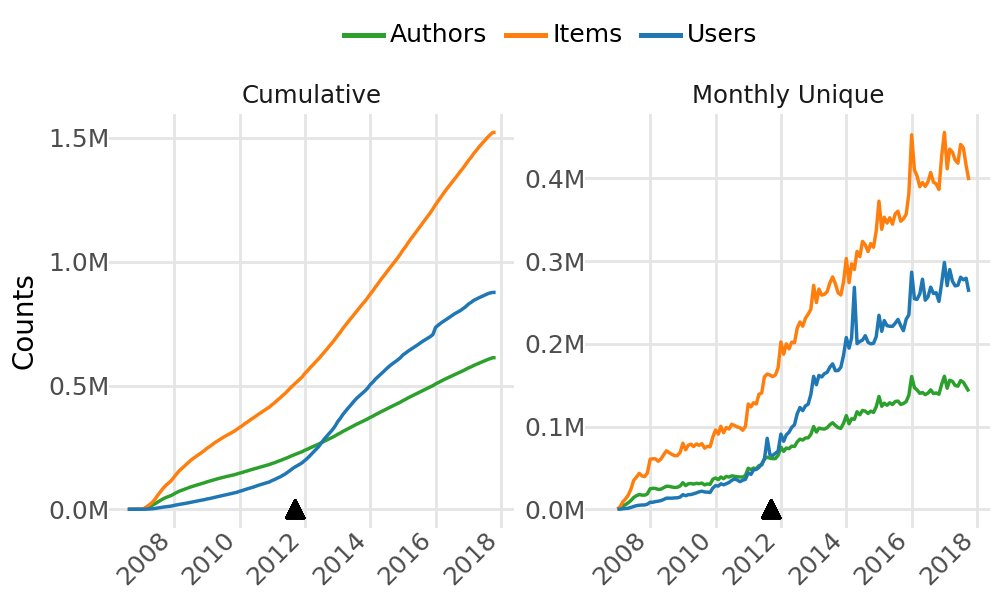

In [13]:
plot = (
    ggplot(df_all, aes(x='date', y='count', color='type')) +
    geom_line(size=0.7) +
    geom_point(aes(x=date_rec_added, y=0), shape='^', color='black', size=3) + \
    scale_color_manual(values={
        'users': '#1f77b4',
        'items': '#ff7f0e',
        'authors': '#2ca02c'
    },
    labels={
        'users': 'Users',
        'items': 'Items',
        'authors': 'Authors'
    }
    ) +
    scale_x_datetime(labels=date_format('%Y'), breaks=date_breaks(width='2 year')) +
    scale_y_continuous(labels=label_number(scale=1e-6, suffix='M')) +
    labs(
        x='',
        y='Counts',
        color='Type'
    ) +
    facet_wrap('~source', scales='free_y') +
    paper_theme +
    theme(figure_size=(5, 3))
)

plot.save(f'{paperplots_path}/entity_counts.png', dpi=300)
plot

In [14]:
df_current = data_metrics[['start_date', 'data_size', 'first_interaction_count']].rename(columns={
    'start_date': 'date',
    'data_size': 'Total Records',
    'first_interaction_count': 'First Actions'
}).melt(id_vars='date', var_name='type', value_name='count')
df_current['source'] = 'Monthly'

df_cumulative = data_metrics[['start_date', 'cumulative_data_size', 'cumulative_first_interactions']].rename(columns={
    'start_date': 'date',
    'cumulative_data_size': 'Total Records',
    'cumulative_first_interactions': 'First Actions'
}).melt(id_vars='date', var_name='type', value_name='count')
df_cumulative['source'] = 'Cumulative'

df_all = pd.concat([df_current, df_cumulative])

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/data_size.png


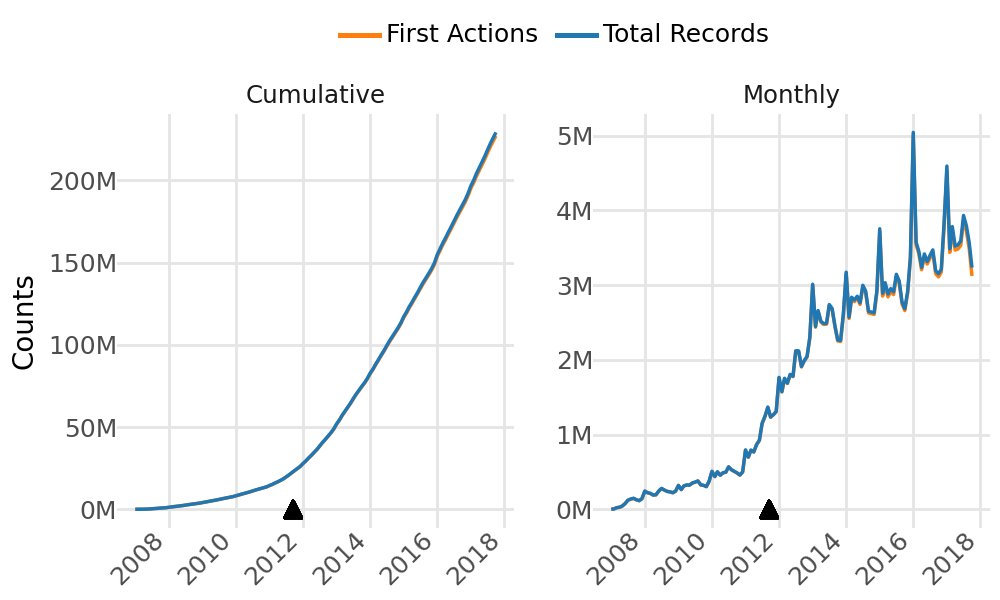

In [15]:
plot = (
    ggplot(df_all, aes(x='date', y='count', color='type')) +
    geom_line(size=0.7) +
    geom_point(aes(x=date_rec_added, y=0), shape='^', color='black', size=3) + \
    scale_color_manual(values={
        'Total Records': '#1f77b4',
        'First Actions': '#ff7f0e'
    }) +
    scale_x_datetime(labels=date_format('%Y'), breaks=date_breaks(width='2 years')) +
    scale_y_continuous(labels=label_number(scale=1e-6, suffix='M')) +
    labs(
        x='',
        y='Counts',
        color='Type'
    ) +
    facet_wrap('~source', scales='free_y') +
    paper_theme +
    theme(figure_size=(5, 3))
)

plot.save(f'{paperplots_path}/data_size.png', dpi=300)
plot

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/entropy.png


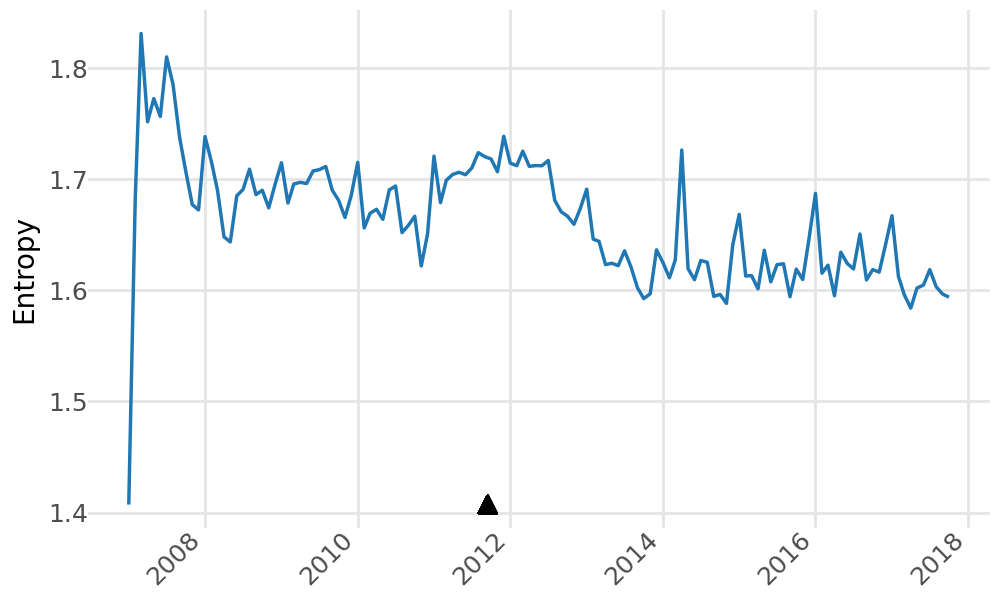

In [16]:
plot = ggplot(data_metrics) + \
  geom_line(aes(x='start_date', y='genre_entropy'), color='#1f77b4', size=0.7) + \
  geom_point(aes(x=date_rec_added, y=data_metrics['genre_entropy'].min()), shape='^', color='black', size=3) + \
  scale_x_datetime(
      labels=date_format('%Y'),
      breaks=date_breaks(width='2 year')
  ) + \
  labs(
      title='',
      x='',
      y='Entropy'
  ) + \
  paper_theme + theme(figure_size=(5,3))

plot.save(f'{paperplots_path}/entropy.png', dpi=300)
plot

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/gini.png


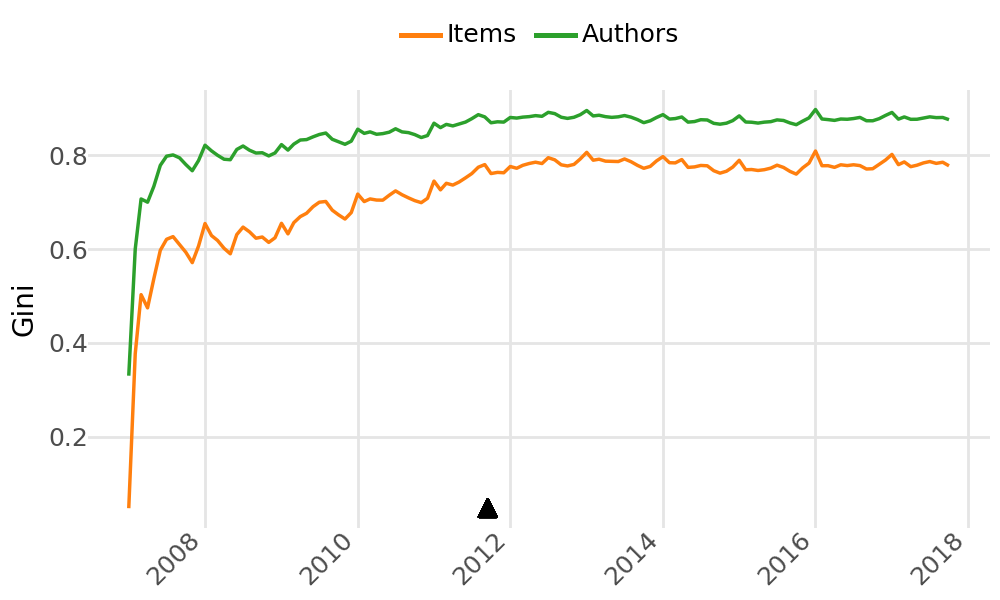

In [17]:
plot = ggplot(data_metrics) + \
  geom_line(aes(x='start_date', y='book_gini', color='"Items"'), size=0.7) + \
  geom_line(aes(x='start_date', y='author_gini', color='"Authors"'), size=0.7) + \
  geom_point(aes(x=date_rec_added, y=data_metrics['book_gini'].min()), shape='^', color='black', size=3) + \
  scale_color_manual(values={
      'Items': '#ff7f0e',
      'Authors': '#2ca02c'
  }) + \
  scale_x_datetime(
      labels=date_format('%Y'),
      breaks=date_breaks(width='2 year')) + \
  scale_y_continuous(
      labels=[0.2, 0.4, 0.6, 0.8],
      breaks=[0.2, 0.4, 0.6, 0.8]) + \
  labs(
      title='',
      x='',
      y='Gini'
  ) + \
  paper_theme + theme(figure_size=(5,3))

plot.save(f'{paperplots_path}/gini.png', dpi=300)
plot

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/female_prop.png


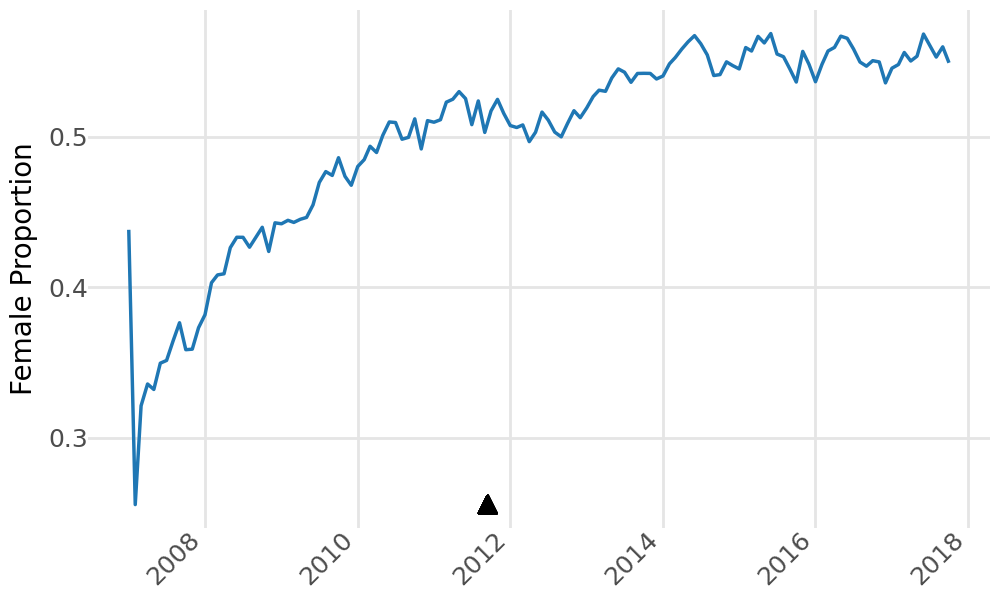

In [18]:
plot = ggplot(data_metrics) + \
  geom_line(aes(x='start_date', y='female_binary'), color='#1f77b4', size=0.7) + \
  geom_point(aes(x=date_rec_added, y=data_metrics['female_binary'].min()), shape='^', color='black', size=3) + \
  scale_x_datetime(
      labels=date_format('%Y'),
      breaks=date_breaks(width='2 year')
  ) + \
  labs(
      title='',
      x='',
      y='Female Proportion'
  ) + \
  paper_theme + theme(figure_size=(5,3))

plot.save(f'{paperplots_path}/female_prop.png', dpi=300)
plot

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/rbp.png


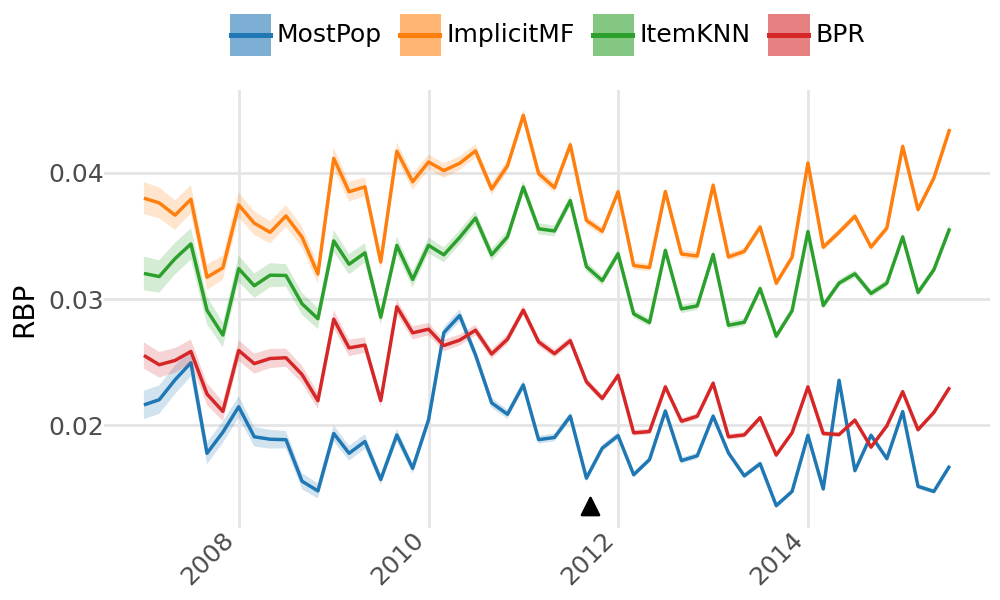

In [19]:
plot = ggplot() + \
  geom_line(aes(x='start_date', y='rbp', color='"MostPop"'), data=popular_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='rbp - rbp_ci', ymax='rbp + rbp_ci', fill='"MostPop"'), 
              data=popular_metrics, alpha=0.2) + \
  geom_line(aes(x='start_date', y='rbp', color='"ImplicitMF"'), data=implicitmf_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='rbp - rbp_ci', ymax='rbp + rbp_ci', fill='"ImplicitMF"'), 
              data=implicitmf_metrics, alpha=0.2) + \
  geom_line(aes(x='start_date', y='rbp', color='"ItemKNN"'), data=itemknn_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='rbp - rbp_ci', ymax='rbp + rbp_ci', fill='"ItemKNN"'), 
              data=itemknn_metrics, alpha=0.2) + \
  geom_line(aes(x='start_date', y='rbp', color='"BPR"'), data=bpr_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='rbp - rbp_ci', ymax='rbp + rbp_ci', fill='"BPR"'), 
              data=bpr_metrics, alpha=0.2) + \
  geom_point(aes(x=date_rec_added, y=popular_metrics['rbp'].min()), shape='^', color='black', size=3) + \
  scale_x_datetime(
      labels=date_format('%Y'),
      breaks=date_breaks(width='2 year')
  ) + \
  scale_color_manual(values={
      'MostPop': '#1f77b4',
      'ImplicitMF': '#ff7f0e',
      'ItemKNN': '#2ca02c',
      'BPR': '#d62728'
  }) + \
  scale_fill_manual(values={
      'MostPop': '#1f77b4',
      'ImplicitMF': '#ff7f0e',
      'ItemKNN': '#2ca02c',
      'BPR': '#d62728'
  }) + \
  labs(
      title='',
      x='',
      y='RBP'
  ) + \
  paper_theme + theme(figure_size=(5,3))

plot.save(f'{paperplots_path}/rbp.png', dpi=300)
plot

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/ndcg.png


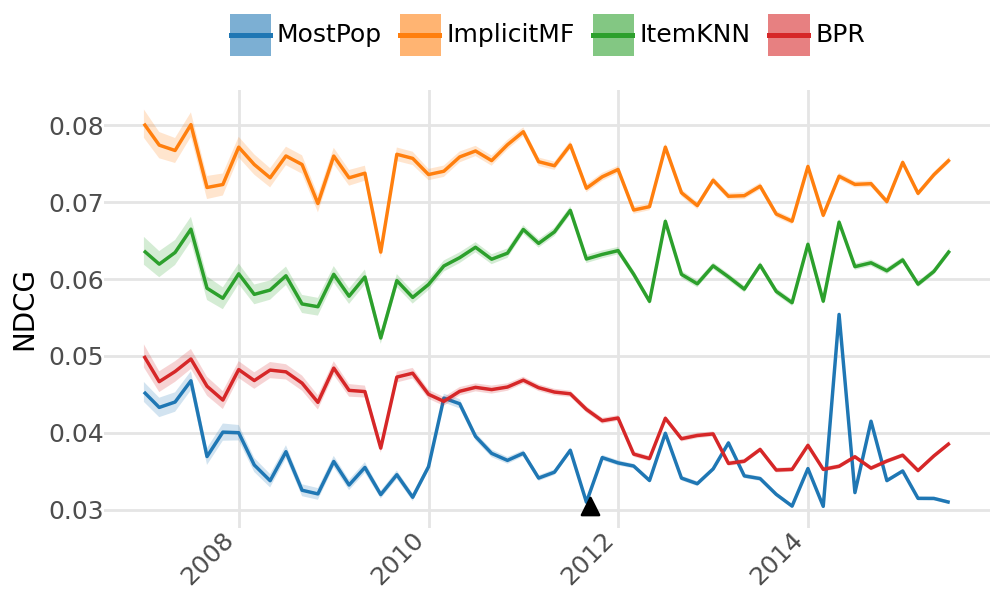

In [20]:
plot = ggplot() + \
  geom_line(aes(x='start_date', y='ndcg', color='"MostPop"'), data=popular_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='ndcg - ndcg_ci', ymax='ndcg + ndcg_ci', fill='"MostPop"'), 
              data=popular_metrics, alpha=0.2) + \
  geom_line(aes(x='start_date', y='ndcg', color='"ImplicitMF"'), data=implicitmf_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='ndcg - ndcg_ci', ymax='ndcg + ndcg_ci', fill='"ImplicitMF"'), 
              data=implicitmf_metrics, alpha=0.2) + \
  geom_line(aes(x='start_date', y='ndcg', color='"ItemKNN"'), data=itemknn_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='ndcg - ndcg_ci', ymax='ndcg + ndcg_ci', fill='"ItemKNN"'), 
              data=itemknn_metrics, alpha=0.2) + \
  geom_line(aes(x='start_date', y='ndcg', color='"BPR"'), data=bpr_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='ndcg - ndcg_ci', ymax='ndcg + ndcg_ci', fill='"BPR"'), 
              data=bpr_metrics, alpha=0.2) + \
  geom_point(aes(x=date_rec_added, y=popular_metrics['ndcg'].min()), shape='^', color='black', size=3) + \
  scale_x_datetime(
      labels=date_format('%Y'),
      breaks=date_breaks(width='2 year')
  ) + \
  scale_color_manual(values={
      'MostPop': '#1f77b4',
      'ImplicitMF': '#ff7f0e',
      'ItemKNN': '#2ca02c',
      'BPR': '#d62728'
  }) + \
  scale_fill_manual(values={
      'MostPop': '#1f77b4',
      'ImplicitMF': '#ff7f0e',
      'ItemKNN': '#2ca02c',
      'BPR': '#d62728'
  }) + \
  labs(
      title='',
      x='',
      y='NDCG'
  ) + \
  paper_theme + theme(figure_size=(5,3))

plot.save(f'{paperplots_path}/ndcg.png', dpi=300)
plot

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/reciprank.png


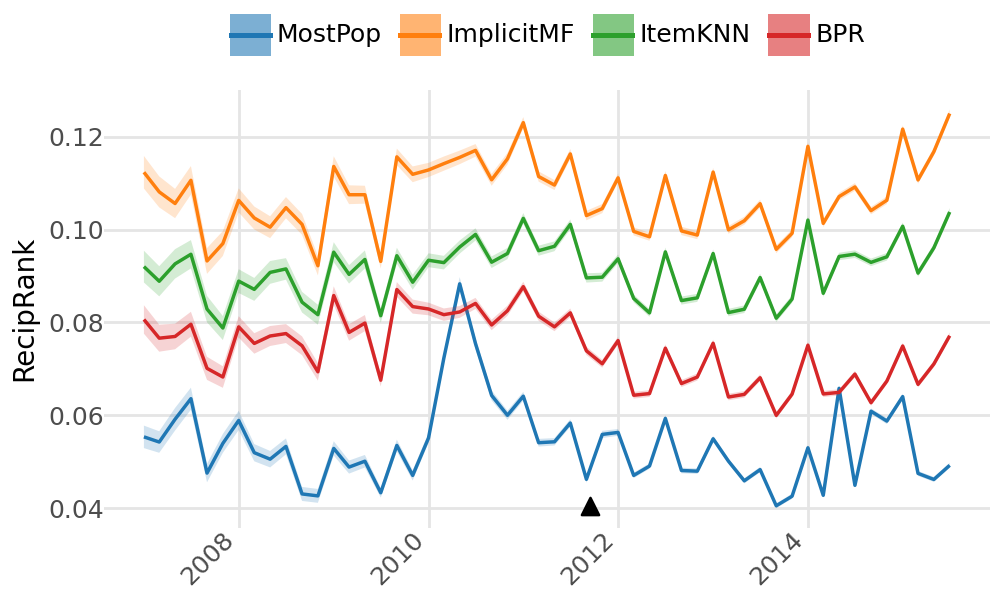

In [21]:
plot = ggplot() + \
  geom_line(aes(x='start_date', y='reciprank', color='"MostPop"'), data=popular_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='reciprank - reciprank_ci', ymax='reciprank + reciprank_ci', fill='"MostPop"'), 
              data=popular_metrics, alpha=0.2) + \
  geom_line(aes(x='start_date', y='reciprank', color='"ImplicitMF"'), data=implicitmf_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='reciprank - reciprank_ci', ymax='reciprank + reciprank_ci', fill='"ImplicitMF"'), 
              data=implicitmf_metrics, alpha=0.2) + \
  geom_line(aes(x='start_date', y='reciprank', color='"ItemKNN"'), data=itemknn_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='reciprank - reciprank_ci', ymax='reciprank + reciprank_ci', fill='"ItemKNN"'), 
              data=itemknn_metrics, alpha=0.2) + \
  geom_line(aes(x='start_date', y='reciprank', color='"BPR"'), data=bpr_metrics, size=0.7) + \
  geom_ribbon(aes(x='start_date', ymin='reciprank - reciprank_ci', ymax='reciprank + reciprank_ci', fill='"BPR"'), 
              data=bpr_metrics, alpha=0.2) + \
  geom_point(aes(x=date_rec_added, y=popular_metrics['reciprank'].min()), shape='^', color='black', size=3) + \
  scale_x_datetime(
      labels=date_format('%Y'),
      breaks=date_breaks(width='2 year')
  ) + \
  scale_color_manual(values={
      'MostPop': '#1f77b4',
      'ImplicitMF': '#ff7f0e',
      'ItemKNN': '#2ca02c',
      'BPR': '#d62728'
  }) + \
  scale_fill_manual(values={
      'MostPop': '#1f77b4',
      'ImplicitMF': '#ff7f0e',
      'ItemKNN': '#2ca02c',
      'BPR': '#d62728'
  }) + \
  labs(
      title='',
      x='',
      y='RecipRank'
  ) + \
  paper_theme + theme(figure_size=(5,3))

plot.save(f'{paperplots_path}/reciprank.png', dpi=300)
plot

In [22]:
def melt_metrics(df, model_name):
    item = df[['start_date', 'unique_item_recs']].copy()
    item['type'] = 'Item'
    item.rename(columns={'unique_item_recs': 'count'}, inplace=True)

    author = df[['start_date', 'unique_author_recs']].copy()
    author['type'] = 'Author'
    author.rename(columns={'unique_author_recs': 'count'}, inplace=True)

    combined = pd.concat([item, author])
    combined['model'] = model_name
    return combined

df_all = pd.concat([
    melt_metrics(popular_metrics, 'MostPop'),
    melt_metrics(implicitmf_metrics, 'ImplicitMF'),
    melt_metrics(itemknn_metrics, 'ItemKNN'),
    melt_metrics(bpr_metrics, 'BPR')
])

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/unique_count_rec.png


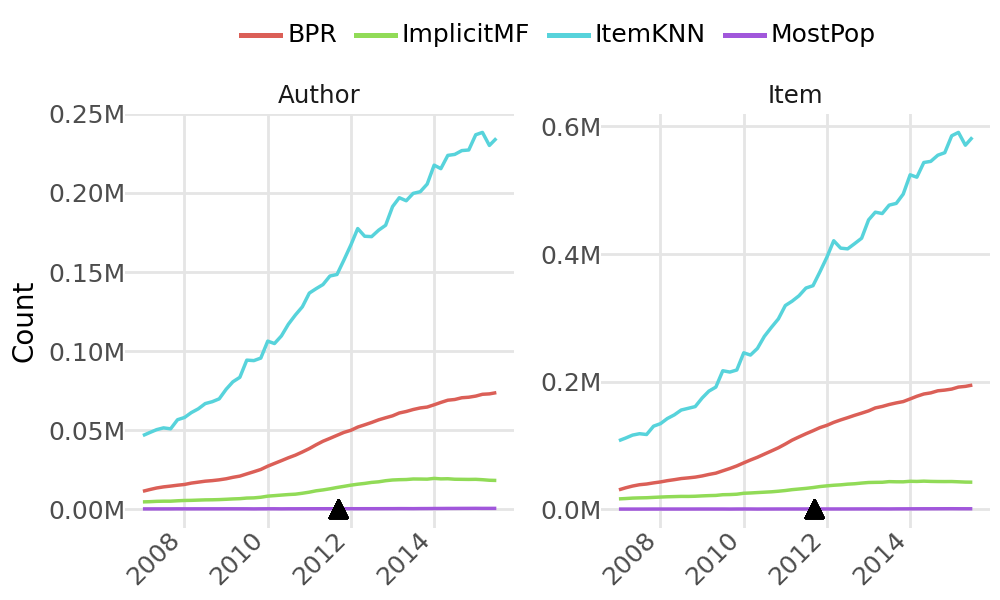

In [23]:
plot = ggplot(df_all, aes(x='start_date', y='count', color='model')) + \
    geom_line(size=0.7) + \
    geom_point(aes(x=date_rec_added, y=0), shape='^', color='black', size=3) + \
    scale_x_datetime(labels=date_format('%Y'), breaks=date_breaks(width='2 year')) + \
    scale_y_continuous(labels=label_number(scale=1e-6, suffix='M')) + \
    labs(
        title='',
        x='',
        y='Count',
        color='Model'
    ) + \
    facet_wrap('~type', scales='free_y') + \
    paper_theme + theme(figure_size=(5,3))


plot.save(f'{paperplots_path}/unique_count_rec.png', dpi=300)
plot

In [24]:
pop = popular_metrics[['start_date', 'genre_entropy']].copy()
pop['model'] = 'MostPop'

imp = implicitmf_metrics[['start_date', 'genre_entropy']].copy()
imp['model'] = 'ImplicitMF'

knn = itemknn_metrics[['start_date', 'genre_entropy']].copy()
knn['model'] = 'ItemKNN'

bpr_df = bpr_metrics[['start_date', 'genre_entropy']].copy()
bpr_df['model'] = 'BPR'

df_entropy = pd.concat([pop, imp, knn, bpr_df], ignore_index=True)

/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/entropy_rec.png


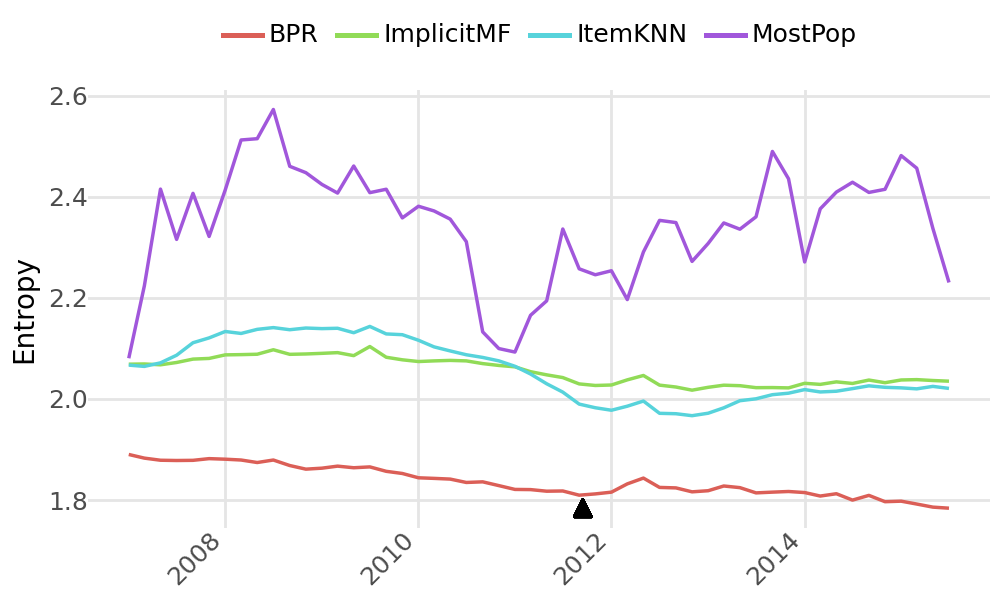

In [25]:
plot= ggplot(df_entropy, aes(x='start_date', y='genre_entropy', color='model')) + \
    geom_line(size=0.7) + \
    geom_point(aes(x=date_rec_added, y=bpr_df['genre_entropy'].min()), shape='^', color='black', size=3) + \
    scale_x_datetime(labels=date_format('%Y'), breaks=date_breaks(width='2 year')) + \
    labs(
        title='',
        x='',
        y='Entropy',
        color='Model'
    ) + \
    paper_theme + theme(figure_size=(5,3))

plot.save(f'{paperplots_path}/entropy_rec.png', dpi=300)
plot

In [26]:
def melt_gini_metrics(df, model_name):
    book_gini = df[['start_date', 'book_exposure_gini']].copy()
    book_gini['type'] = 'Book Exposure Gini'
    book_gini.rename(columns={'book_exposure_gini': 'gini'}, inplace=True)

    author_gini = df[['start_date', 'author_gini']].copy()
    author_gini['type'] = 'Author Exposure Gini'
    author_gini.rename(columns={'author_gini': 'gini'}, inplace=True)

    combined = pd.concat([book_gini, author_gini])
    combined['model'] = model_name
    return combined

df_gini_all = pd.concat([
    melt_gini_metrics(popular_metrics, 'MostPop'),
    melt_gini_metrics(implicitmf_metrics, 'ImplicitMF'),
    melt_gini_metrics(itemknn_metrics, 'ItemKNN'),
    melt_gini_metrics(bpr_metrics, 'BPR')
])

min_gini = df_gini_all.groupby('type')['gini'].min().reset_index()
min_gini = min_gini.rename(columns={'gini': 'min_gini'})

df_gini_all = df_gini_all.merge(min_gini, on='type', how='left')

In [27]:
df_gini_all.head()

,start_date,gini,type,model,min_gini
0,2007-01-01,0.999794,Book Exposure Gini,MostPop,0.950437
1,2007-03-01,0.999806,Book Exposure Gini,MostPop,0.950437
2,2007-05-01,0.999813,Book Exposure Gini,MostPop,0.950437
3,2007-07-01,0.999818,Book Exposure Gini,MostPop,0.950437
4,2007-09-01,0.999822,Book Exposure Gini,MostPop,0.950437


/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/gini_rec.png


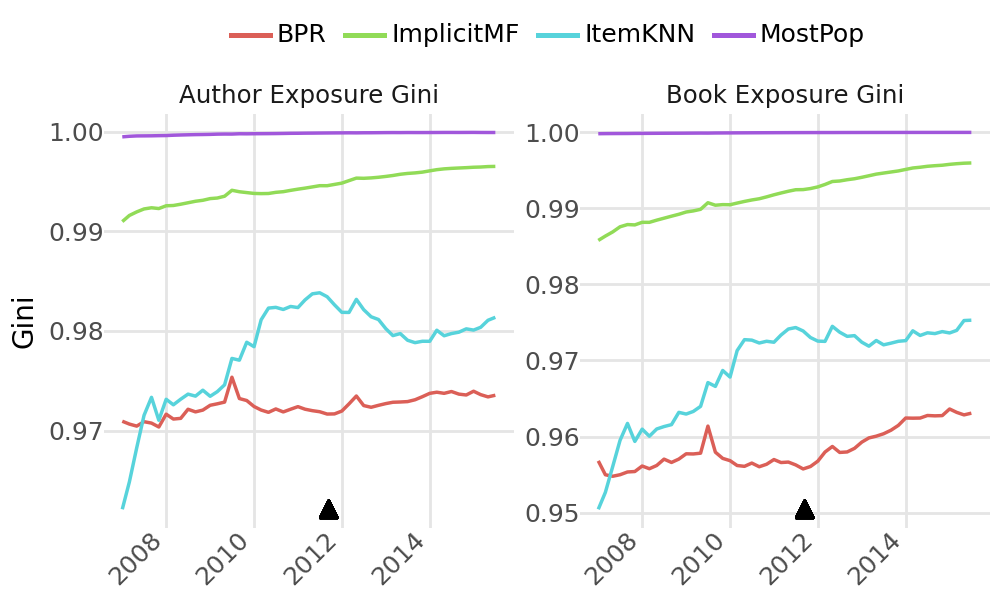

In [28]:
plot = ggplot(df_gini_all, aes(x='start_date', y='gini', color='model')) + \
    geom_line(size=0.7) + \
    geom_point(aes(x=date_rec_added, y=df_gini_all['min_gini']), shape='^', color='black', size=3) + \
    scale_x_datetime(labels=date_format('%Y'), breaks=date_breaks(width='2 year')) + \
    labs(
        title='',
        x='',
        y='Gini',
        color='Model'
    ) + \
    facet_wrap('~type', scales='free_y') + \
    paper_theme + theme(figure_size=(5, 3))

plot.save(f'{paperplots_path}/gini_rec.png', dpi=300)
plot

In [29]:
gender_popular = popular_metrics['gender_prop'].apply(pd.Series)
gender_binary_popular = popular_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_popular.columns = ['male_binary', 'female_binary']

gender_implicitmf = implicitmf_metrics['gender_prop'].apply(pd.Series)
gender_binary_implicitmf = implicitmf_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_implicitmf.columns = ['male_binary', 'female_binary']

gender_itemknn = itemknn_metrics['gender_prop'].apply(pd.Series)
gender_binary_itemknn = itemknn_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_itemknn.columns = ['male_binary', 'female_binary']

gender_bpr = bpr_metrics['gender_prop'].apply(pd.Series)
gender_binary_bpr = bpr_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_bpr.columns = ['male_binary', 'female_binary']

gender_binary_bpr.head()

,male_binary,female_binary
0,0.596088,0.403912
1,0.586664,0.413336
2,0.576378,0.423622
3,0.575029,0.424971
4,0.569015,0.430985


In [30]:
def melt_gender_metrics(metrics_df, gender_df, model_name):
    df = metrics_df[['start_date']].copy()
    df['female_prop'] = gender_df['female_binary']
    df['model'] = model_name
    return df

df_gender = pd.concat([
    melt_gender_metrics(popular_metrics, gender_binary_popular, 'MostPop'),
    melt_gender_metrics(implicitmf_metrics, gender_binary_implicitmf, 'ImplicitMF'),
    melt_gender_metrics(itemknn_metrics, gender_binary_itemknn, 'ItemKNN'),
    melt_gender_metrics(bpr_metrics, gender_binary_bpr, 'BPR')
])

df_gender.head()

,start_date,female_prop,model
0,2007-01-01,0.331205,MostPop
1,2007-03-01,0.327602,MostPop
2,2007-05-01,0.317436,MostPop
3,2007-07-01,0.339737,MostPop
4,2007-09-01,0.346307,MostPop


/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 5 x 3 in image.
/storage/sp3886/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ../outputs/paperplots/female_prop_rec.png


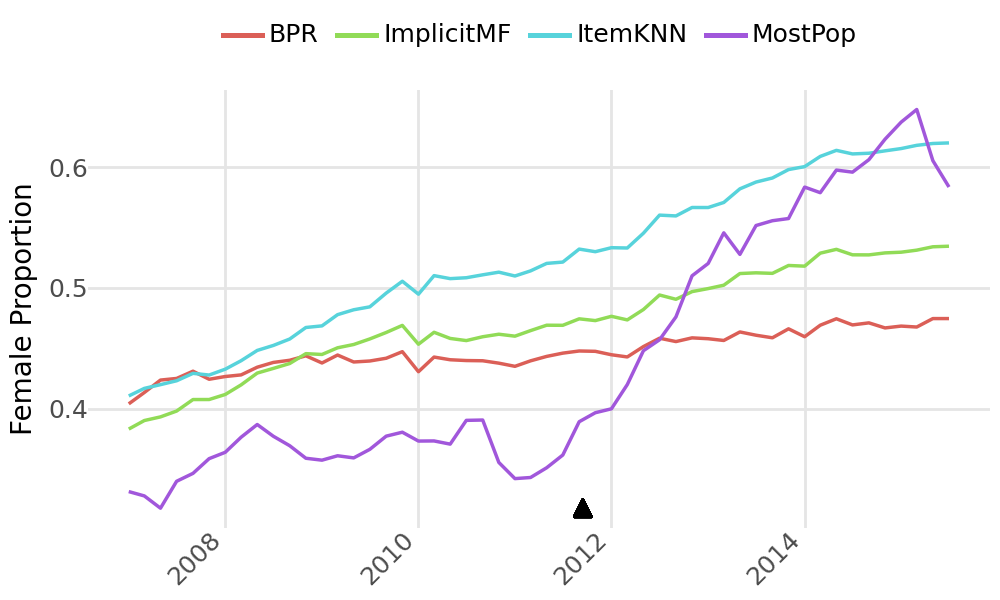

In [31]:
plot = ggplot(df_gender, aes(x='start_date', y='female_prop', color='model')) + \
    geom_line(size=0.7) + \
    geom_point(aes(x=date_rec_added, y=df_gender['female_prop'].min()), shape='^', color='black', size=3) + \
    scale_x_datetime(labels=date_format('%Y'), breaks=date_breaks(width='2 year')) + \
    labs(
        title='',
        x='',
        y='Female Proportion',
        color='Model'
    ) + \
    paper_theme + theme(figure_size=(5,3))

plot.save(f'{paperplots_path}/female_prop_rec.png', dpi=300)
plot